In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

In [2]:
from Networks import *

C:\Users\Anka\anaconda3\envs\chbcapture\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Anka\anaconda3\envs\chbcapture\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Anka\anaconda3\envs\chbcapture\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Anka\anaconda3\envs\chbcapture\lib\site-packages\ten

In [3]:
from Utility import *
import Logger

In [4]:
from matplotlib import pyplot as plt

In [5]:
dataFolder = r'Z:\2021_03_01_RandomlyDeformedGridMesh\Data128'
outputFolder = r'Z:\2021_03_01_RandomlyDeformedGridMesh\Training128'
numMarkers = 50
markerSelected = 47

numTest = 200

In [6]:
imgsPerMaker = []
uvsPerMaker = []

for iM in range(numMarkers):
    outImgDataFile = join(dataFolder, 'ImgMarker_' + str(iM).zfill(3) + '.npy')
    outUVDataFile = join(dataFolder, 'UVMarker_' + str(iM).zfill(3) + '.npy')

    img = np.load(outImgDataFile)
    uv = np.load(outUVDataFile)
    
    imgsPerMaker.append(img)
    uvsPerMaker.append(uv)

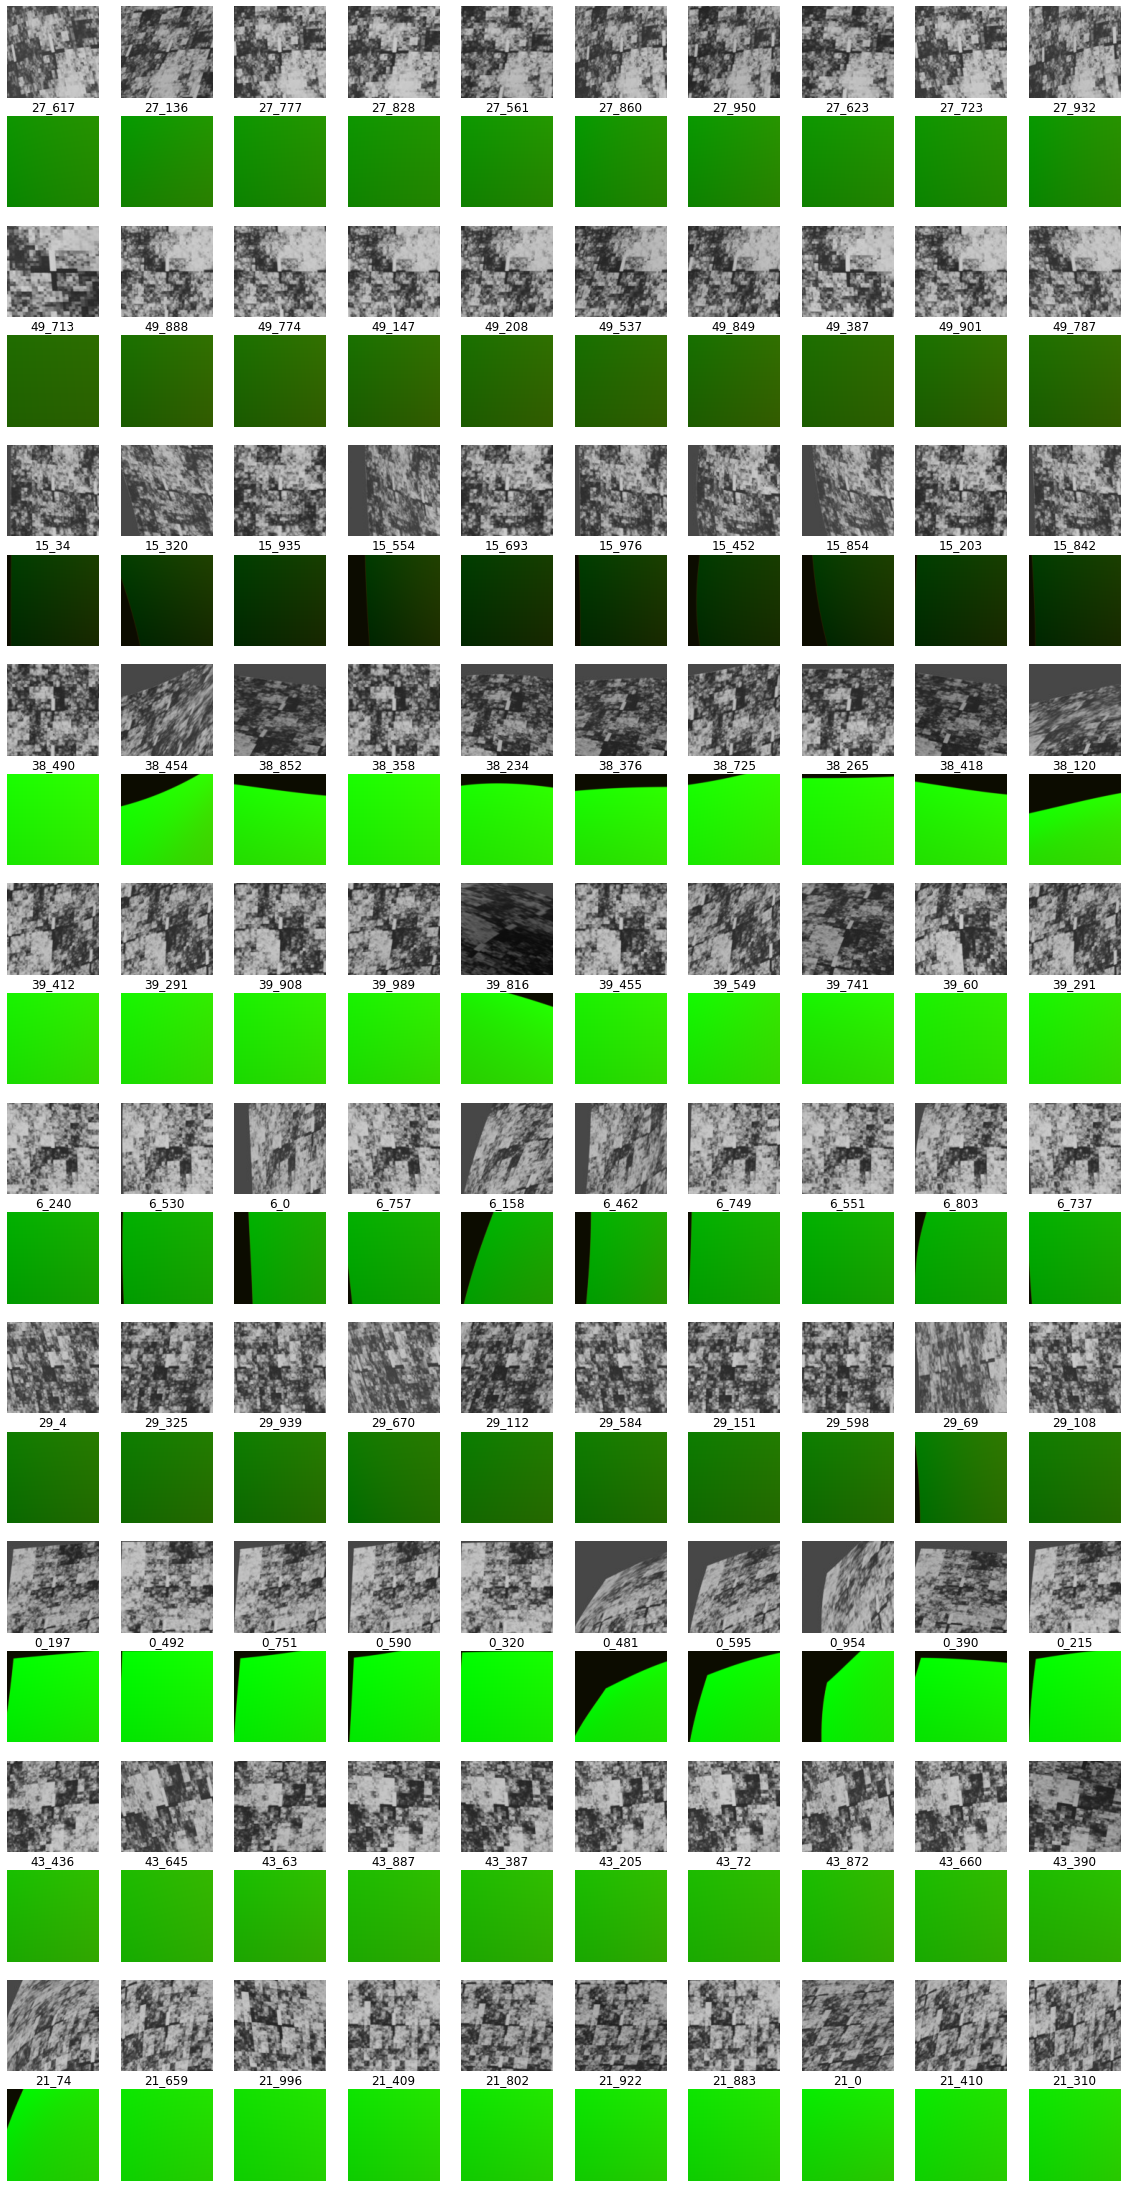

In [7]:
gridH = 20
gridW = 10
fig, axs = plt.subplots(gridH, gridW)


fig.set_size_inches(20, 20*(gridH/gridW))
for i, iMarker in enumerate(range(int(gridH/2))):
    marker = np.random.randint(0, len(imgsPerMaker))
    imgIds = np.random.randint(0, len(imgsPerMaker[marker]), size=(gridW,))
    for j, iImg in enumerate(imgIds):
        axs[i*2, j].imshow(imgsPerMaker[marker][iImg, ...], cmap="gray")
        axs[i*2, j].axis('off')
    
        axs[i*2+1, j].imshow(predToRGB(uvsPerMaker[marker][iImg, ...]), )
        axs[i*2+1, j].set_title("%d_%d" % (marker, iImg))
        axs[i*2+1, j].axis('off')
    
    
    

In [8]:
# uvExtractor = UVExtractor('resnet_101', training=False,  pre_trained_model=r'C:\Code\MyRepo\00_DeepLearning\DeepLab-V3\data\models\pretrained\resnet_101\resnet_v2_101.ckpt')
uvExtractor = UVExtractor('resnet_50', training=True, inputShape=[None,128,128,3], labelShape=[None, 128,128,2])

In [9]:
fd = {uvExtractor.inputs:imgsPerMaker[0][:10, :,:,:],
      uvExtractor.is_training:False,
      uvExtractor.target_width:128,
      uvExtractor.target_height:128,
      uvExtractor.labels:uvsPerMaker[0][:10, ...]
     }
featureMap = uvExtractor.sess.run(uvExtractor.outputs, feed_dict=fd)
print(featureMap.shape)

(10, 32, 32, 2)


In [10]:
np.max(uv[..., 0]) - np.min(uv[..., 0])

0.2878467144910246

In [11]:
numData = imgsPerMaker[markerSelected].shape[0]
sizeTrain = numData - numTest

trainData = imgsPerMaker[markerSelected][:-numTest, ...]
trainUV = uvsPerMaker[markerSelected][:-numTest, ...]

testData = imgsPerMaker[markerSelected][-numTest:, ...]
testUV = uvsPerMaker[markerSelected][-numTest:, ...]

errInfo={
    'Train':[],
    'Validation':[]

}

In [12]:
saver = tf.train.Saver()

os.makedirs(outputFolder, exist_ok=True)
logFile = join(outputFolder, 'Logs.txt')
logger = Logger.configLogger(logFile)

In [16]:
numEpoch = 50000
batchSize = 32
weight_decay = 5e-4
lr = 1e-5
saveStep = 100
iEpoch = 0
plotStep = 10



plt.figure()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
numBatch = int(np.ceil(sizeTrain / batchSize))

while iEpoch < numEpoch:
    for iBatch in range(numBatch):
        fd = {uvExtractor.inputs:trainData[iBatch*batchSize:(iBatch+1)*batchSize, :,:,:],
              uvExtractor.is_training:True,
              uvExtractor.target_width:128,
              uvExtractor.target_height:128,
              uvExtractor.labels:trainUV[iBatch*batchSize:(iBatch+1)*batchSize, ...],
              uvExtractor.weight_decay: weight_decay,
              uvExtractor.learning_rate: lr
             }
        _ = uvExtractor.sess.run(uvExtractor.optimizer, feed_dict=fd)

    
    evalTrain = evaluate(trainData, trainUV, uvExtractor, batchSize=batchSize, perImgEval=False)    
    evalTest = evaluate(testData, testUV, uvExtractor, batchSize=batchSize, perImgEval=False)    
    
    if not iEpoch % saveStep:
        save_path = saver.save(uvExtractor.sess, join(outputFolder, "N03_UVExtractor_128_"+str(iEpoch).zfill(6)+".ckpt"))
        print("Saved check point to: ", save_path)
        
    infoStr = f'mean train err: %8.8g, max train err: %8.8g, mean val err: %8.8g, max val err:  %8.8g' \
        % (evalTrain['MeanErr'], evalTrain['MaxErr'], evalTest['MeanErr'],  evalTest['MaxErr'])
    
    logger.info(infoStr)
    
    if iEpoch % plotStep == 0 and i:
        print(infoStr)
        fig, a_loss = plt.subplots()
        errInfo['Train'].append(evalTrain)
        errInfo['Validation'].append(evalTest)
        
        json.dump(errInfo, open(join(outputFolder, 'Errors.json'), 'w'))
        
        trainMeanErrs = [err['MeanErr'] for err in  errInfo['Train']]
        valMeanErrs = [err['MeanErr'] for err in errInfo['Validation']]
        plt.close('all')
        X = list(range(len(trainMeanErrs)))
        a_loss.plot(X, trainMeanErrs, label = "mean training error")
        a_loss.plot(X, valMeanErrs, label = "mean validation error")
        
        a_loss.set_xlabel('iteration')
        # Set the y axis label of the current axis.
        a_loss.set_ylabel('mean localiztion error')
        a_loss.grid()
        a_loss.legend()
        fig.savefig(join(outputFolder,
                         'ErrCurve.png'),
                    dpi=256, transparent=False, bbox_inches='tight', )
        
    iEpoch += 1

Saved check point to:  Z:\2021_03_01_RandomlyDeformedGridMesh\Training128\N03_UVExtractor_128_000000.ckpt
2021-03-07 16:17:42,796 logger INFO mean train err: 0.58432158, max train err: 4.3200992, mean val err: 0.62881557, max val err:  4.5221734
mean train err: 0.58432158, max train err: 4.3200992, mean val err: 0.62881557, max val err:  4.5221734
2021-03-07 16:18:14,893 logger INFO mean train err: 0.53445164, max train err: 3.9490503, mean val err: 0.60230628, max val err:  4.353536
2021-03-07 16:18:47,060 logger INFO mean train err: 0.49537814, max train err: 3.7506265, mean val err: 0.57985972, max val err:  4.1747642
2021-03-07 16:19:19,388 logger INFO mean train err: 0.46446822, max train err: 3.5824438, mean val err: 0.56065175, max val err:  4.0133131
2021-03-07 16:19:51,761 logger INFO mean train err: 0.44001243, max train err: 3.4359735, mean val err: 0.54395055, max val err:  4.0124381
2021-03-07 16:20:24,368 logger INFO mean train err: 0.41921777, max train err: 3.2391613, m

In [ ]:
saver = tf.train.Saver()
save_path = saver.save(uvExtractor.sess, r"C:\Code\MyRepo\03_capture\DenseLocalizationTexture\S03_NetworksTraining\Save\N02_UVExtractor_DeepLabStructure_SingleMarker_epoch_"+str(iEpoch).zfill(6)+".ckpt")
print("Model saved in path: %s" % save_path)

In [ ]:
fdVal = {uvExtractor.inputs:trainData[100:101, ...],
              uvExtractor.is_training:True,
              uvExtractor.target_width:60,
              uvExtractor.target_height:60,
              uvExtractor.labels:trainUV[:1, ...],
              uvExtractor.weight_decay: weight_decay,
              uvExtractor.learning_rate: lr
             }
outputs = uvExtractor.sess.run(uvExtractor.outputs_resized, feed_dict=fdVal)

In [ ]:
pred = np.stack([outputs[..., 0], outputs[..., 1], np.zeros(outputs[..., 1].shape)], -1)

In [ ]:
plt.imshow(pred[0,...])

In [ ]:
plt.imshow(predToRGB(trainUV[100,...]))

In [ ]:
np.mean(np.abs(outputs[0,...] - trainUV[0,...]))

In [ ]:
figs, axs = plt.subplots(10, 4)

for iIm in range(10):
    for iFig in range(4):
        fdVal = {uvExtractor.inputs:trainData[100:101, ...],
              uvExtractor.is_training:True,
              uvExtractor.target_width:60,
              uvExtractor.target_height:60,
              uvExtractor.labels:trainUV[:1, ...],
              uvExtractor.weight_decay: weight_decay,
              uvExtractor.learning_rate: lr
             }
        outputs = uvExtractor.sess.run(uvExtractor.outputs_resized, feed_dict=fdVal)
